In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-science-bowl-2018/stage1_test.zip
/kaggle/input/data-science-bowl-2018/stage1_sample_submission.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_sample_submission_final.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_train.zip
/kaggle/input/data-science-bowl-2018/stage1_train_labels.csv.zip
/kaggle/input/data-science-bowl-2018/stage1_solution.csv.zip
/kaggle/input/data-science-bowl-2018/stage2_test_final.zip


In [2]:
train_path = os.path.join(dirname, filenames[3]) #path to train data


from PIL import Image
from zipfile import ZipFile

train_zip = ZipFile(train_path) #get data from zipped file (train)
train_zip.extractall() #extract data to current directory (train)
current_directory = os.getcwd() #get current directory (train)

In [3]:
#data augmentation (grid distortion, optical distortion is particularly useful for biomedical image segmentation)


from albumentations import RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip, Transpose, OpticalDistortion

def DataAugmentation(x_array, y_array):

 #   aug = RandomRotate90(p=1.0)
 #   augmented = aug(image=x_array, mask=y_array)
 #   x2 = augmented['image']; y2 = augmented['mask']

    aug = GridDistortion(p=1.0)
    augmented = aug(image=x_array, mask=y_array)
    x3 = augmented['image']; y3 = augmented['mask']

  #  aug = HorizontalFlip(p=1.0)
  #  augmented = aug(image=x_array, mask=y_array)
  #  x4 = augmented['image']; y4 = augmented['mask']

  #  aug = VerticalFlip(p=1.0)
  #  augmented = aug(image=x_array, mask=y_array)
  #  x5 = augmented['image']; y5 = augmented['mask']

  #  aug = Transpose(p=1.0)
  #  augmented = aug(image=x_array, mask=y_array)
  #  x6 = augmented['image']; y6 = augmented['mask']

    aug = OpticalDistortion(p=1.0)
    augmented = aug(image=x_array, mask=y_array)
    x7 = augmented['image']; y7 = augmented['mask']

   # X = [x_array, x2, x3, x4, x5, x6, x7]
   # Y = [y_array, y2, y3, y4, y5, y6, y7]
    
    X = [x_array, x3, x7]
    Y = [y_array, y3, y7]
       

    return X, Y
# after optimizing the model it appears that using grid distortion and optical distortion
#only work better than combined others (commented above)

In [4]:
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# image preparation part (X_train, y_train)

train_ids = next(os.walk(current_directory))[1] #name of folders in train set
size = 256 #resize all images to this value

train_x = []
train_y = []

for i, ids in tqdm(enumerate(train_ids[:600])): # i chose only 600/670 images for training
    #name of folder and name of image is same :ids
    training_path_x = current_directory + '/' + ids + '/images/' + ids + '.png'
    
    image = imread(training_path_x)[:,:,:3] # no need for alpha channel here
    resized_image = resize(image, (size, size))
    
    #train_y is a bit difficult: each nucleus is in saparate image (see masks folder for details)
    #therefore I have to combine them. 
    training_path_y =  current_directory + '/' + ids + '/masks/'
    namelist = os.listdir(training_path_y) # name of every nucleus for single train_x image
    combined_mask = np.zeros((size,size))
    
    for y_ids in namelist:
        mask_j = imread(training_path_y + y_ids)
        resized_mask = resize(mask_j, (size, size))
        combined_mask = np.maximum(combined_mask, resized_mask) #combine all nuclei into one image

    # need augmentation to increase training data
    
    X, Y = DataAugmentation(resized_image, combined_mask)
    train_x.append(X); train_y.append(Y) 
    

train_x = np.array(train_x).reshape(-1,size,size,3)
train_y = np.array(train_y, dtype = bool).reshape(-1, size, size) # training data is ready



600it [07:24,  1.35it/s]


In [5]:
# data for testing remaining data (600-670) are used for testing

test_x = np.zeros((70,size,size,3))
test_y = np.zeros((70, size, size))

for i, ids in tqdm(enumerate(train_ids[600:])):
    #name of folder and name of image is same :ids
    training_path_x = current_directory + '/' + ids + '/images/' + ids + '.png'
    image = imread(training_path_x)[:,:,:3] # no need for alpha channel here
    resized_image = resize(image, (size, size))
    test_x[i,] = resized_image
    
    
    training_path_y =  current_directory + '/' + ids + '/masks/'
    namelist = os.listdir(training_path_y) # name of every nucleus for single train_x image
    
    combined_mask = np.zeros((size,size))
    for y_ids in namelist:
        mask_j = imread(training_path_y + y_ids)
        resized_mask = resize(mask_j, (size, size))
        combined_mask = np.maximum(combined_mask, resized_mask) #combine all nucleus in one image
    
    test_y[i,] = combined_mask #testing/validation data is ready

70it [00:43,  1.60it/s]


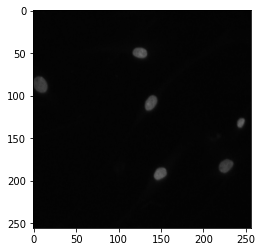

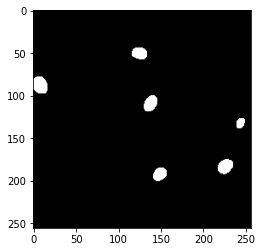

In [6]:
plt.imshow(train_x[0])
plt.show() 
plt.imshow(train_y[0], cmap = 'gray')
plt.show()
    

In [7]:
#normalizing data and centering it at 0

mean_pixel = train_x.mean(axis = (0,1,2), keepdims = True)
std_pixel = train_x.std(axis = (0,1,2), keepdims = True)
train_x = (train_x - mean_pixel)/std_pixel
test_x = (test_x - mean_pixel)/std_pixel

In [14]:
### U-net model
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, concatenate, Conv2DTranspose
import tensorflow as tf
init = tf.keras.initializers.he_normal() #initializer for weight matrices

width = 256; height = 256; channel = 3
inputs = Input((height, width, channel))

## Contraction
c1 = Conv2D(32, (3,3), activation = "relu", kernel_initializer = init, padding = 'same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(32, (3,3), activation = 'relu', kernel_initializer = init, padding = 'same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(64, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(64, (3,3), activation='relu', kernel_initializer= init, padding = 'same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(128, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(128, (3,3), activation='relu', kernel_initializer= init, padding = 'same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(256, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(p3)
c4 = Dropout(0.2)(c4)
c4 =  Conv2D(256, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(512, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(p4)
c5 = Dropout(0.3)(c5)
c5 =  Conv2D(512, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(c5)


## Expansion
u6 = Conv2DTranspose(256, (2,2), strides = (2,2), padding = 'same')(c5)
u6 = concatenate([u6,c4])
c6 = Conv2D(256, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(u6)
c6 = Dropout(0.2)(c6)
c6 =  Conv2D(256, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(c6)

u7 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = 'same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(u7)
c7 = Dropout(0.2)(c7)
c7 =  Conv2D(128, (3,3), activation='relu', kernel_initializer = init, padding = 'same')(c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same')(c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same')(c9)


outputs = Conv2D(1, (1,1), activation = 'sigmoid')(c9)
unet_model = tf.keras.Model(inputs = inputs, outputs = outputs)
unet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
unet_model.summary()

#####

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 32) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 9248        dropout_9[0][0]                  
____________________________________________________________________________________________

In [15]:
results = unet_model.fit(train_x, train_y, validation_split=0.1, batch_size=32, epochs=10)

Epoch 1/10
51/51 [==============================] - 18s 309ms/step - loss: 0.4322 - accuracy: 0.8443 - val_loss: 0.2302 - val_accuracy: 0.9119
Epoch 2/10
51/51 [==============================] - 15s 300ms/step - loss: 0.1987 - accuracy: 0.9225 - val_loss: 0.1304 - val_accuracy: 0.9513
Epoch 3/10
51/51 [==============================] - 15s 301ms/step - loss: 0.1294 - accuracy: 0.9516 - val_loss: 0.1056 - val_accuracy: 0.9612
Epoch 4/10
51/51 [==============================] - 15s 299ms/step - loss: 0.1039 - accuracy: 0.9601 - val_loss: 0.0857 - val_accuracy: 0.9683
Epoch 5/10
51/51 [==============================] - 15s 303ms/step - loss: 0.0922 - accuracy: 0.9644 - val_loss: 0.0787 - val_accuracy: 0.9697
Epoch 6/10
51/51 [==============================] - 15s 300ms/step - loss: 0.0867 - accuracy: 0.9663 - val_loss: 0.0702 - val_accuracy: 0.9735
Epoch 7/10
51/51 [==============================] - 15s 301ms/step - loss: 0.0768 - accuracy: 0.9694 - val_loss: 0.0668 - val_accuracy: 0.9737

In [16]:
#validation of the model on completely unseen data

preds = unet_model.predict(test_x, verbose = True)
predicted = (preds>0.5).astype(int)
test_y = test_y.reshape(70,256,256,1)

3/3 [==============================] - 0s 79ms/step


In [17]:
accuracy = []
for k in range(predicted.shape[0]):
    accuracy_k = (predicted[k] == test_y[k]).sum()/(256*256)
    accuracy.append(accuracy_k)
np.mean(accuracy)
# ~0.90/1 accuracy

0.9043705531529018

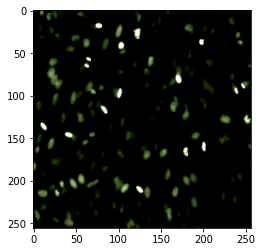

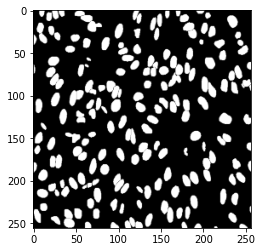

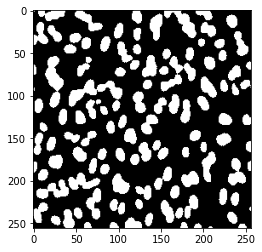

In [12]:
plt.imshow(test_x[3])
plt.show() 
plt.imshow(test_y[3], cmap = 'gray')
plt.show()
plt.imshow(predicted[3], cmap = 'gray')
plt.show() 